In [6]:
import warnings
warnings.filterwarnings("ignore")
from joblib import parallel_backend
import multiprocessing

n_cores = multiprocessing.cpu_count()
import csv

# Wdbc

Số lõi CPU có sẵn: 20
Model: Pin-FS-SVM

Xử lý file: wdbc.data.txt
Not noise
Best B value: 5
Best C: 0.125
Best tau: 0.1
Best Accuracy on 10-CV: 0.9771303258145363
Best AUC on 10-CV:  0.9730605076826052
Average time per fold: 0.28 seconds
v: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0.]
Features selected: [8, 22, 24, 25, 29]
Number of selected features: 5
----------------------------------------------------------------------------------------------------

Xử lý file: wdbc_noisy_label_feature.txt
Noise
Best B value: 14
Best C: 0.5
Best tau: 1
Best Accuracy on 10-CV: 0.9016290726817042
Best AUC on 10-CV:  0.9015203599813987
Average time per fold: 0.27 seconds
v: [0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1.]
Features selected: [3, 4, 7, 9, 11, 17, 21, 22, 24, 26, 27, 28, 29, 30]
Number of selected features: 14
---------------------------------------------------------------------------------------

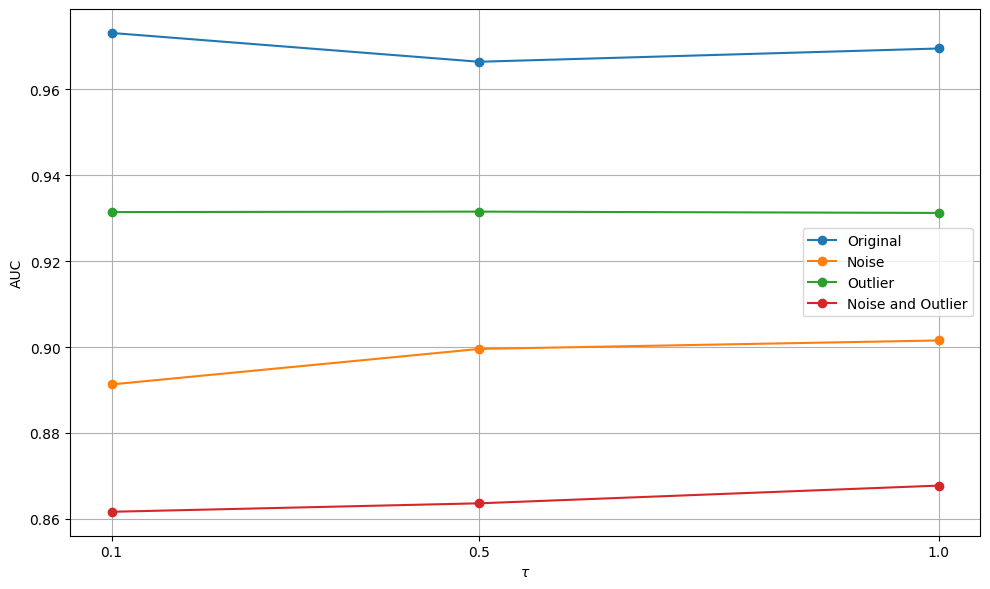

In [7]:
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import time
import multiprocessing
from joblib import parallel_backend
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 

n_cores = multiprocessing.cpu_count()
print(f"Số lõi CPU có sẵn: {n_cores}")

# Danh sách các file dữ liệu
file_names = [
    'wdbc.data.txt',
    'wdbc_noisy_label_feature.txt',
    'wdbc_noisy_label_outlier.txt',
    'wdbc_both_noise_outlier.txt'
]

print('Model: Pin-FS-SVM')
results = []
max_time_per_file = 60 * 60  # 30 phút
# Khởi tạo figure và axes cho các biểu đồ
fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False)
axs = axs.ravel()
plot_index = 0
dataset_tau_auc = {}
for iteration, file_name in enumerate(file_names):
    print(f"\nXử lý file: {file_name}")
    if iteration == 0: 
        print('Not noise')
        noise_type = 'Original'
    elif iteration == 1:
        print('Noise')
        noise_type = 'Noise'
    elif iteration == 2:
        print('Outlier')
        noise_type = 'Outlier'
    else:
        noise_type = 'Noise and Outlier'
    
    df = pd.read_csv(file_name, header=None)

    # Tách dữ liệu và nhãn
    X = df.iloc[:, 2:].values
    y = df.iloc[:, 1].values

    # Chuyển đổi nhãn từ B/M thành -1/1
    y = np.where(y == 'M', 1, -1)

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()

    # Các tham số của mô hình
    l = [-2] * X.shape[1]
    u = [2] * X.shape[1]
    C_values = [2**i for i in range(-3, 6)]
    tau_values = [0.1, 0.5, 1]

    best_B = None
    best_mean_cv_accuracy = 0
    best_mean_cv_AUC = 0
    no_improvement_count = 0
    dataset_tau_auc = {}

    n = X.shape[1]
    B_values = [i for i in range(1, n+1)]

    start_file_time = time.time()

    with parallel_backend('loky', n_jobs=n_cores):
        for tau in tau_values:
            best_mean_cv_AUC_for_tau = 0
            for C in C_values:
                for B in B_values:
                    current_time = time.time()
                    if current_time - start_file_time > max_time_per_file:
                        break
                    kf = KFold(n_splits=10, shuffle=True, random_state=42)
                    cv_accuracies = []
                    cv_AUC = []
                    cv_times = []

                    for train_index, val_index in kf.split(X):
                        start_time = time.time()
                        X_cv_train, X_cv_val = X[train_index], X[val_index]
                        y_cv_train, y_cv_val = y[train_index], y[val_index]

                        # Chuẩn hóa dữ liệu
                        X_cv_train = scaler.fit_transform(X_cv_train)
                        X_cv_val = scaler.transform(X_cv_val)

                        # Khởi tạo mô hình
                        opt_mod = Model(name='Pin-FS-SVM')
                        m, n = X_cv_train.shape

                        # Các biến quyết định
                        w = opt_mod.continuous_var_list(n, name='w')
                        b = opt_mod.continuous_var(name='b')
                        v = opt_mod.binary_var_list(n, name='v')
                        xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
                        z = opt_mod.continuous_var_list(n, lb=0, name='z')

                        # Hàm mục tiêu
                        opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))

                        # Ràng buộc phân loại
                        for i in range(m):
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) >= 1 - xi[i])
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau))

                        # Ràng buộc tổng các đặc trưng được chọn
                        opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)

                        # Ràng buộc cho w_j^+ và w_j^-
                        for j in range(n):
                            opt_mod.add_constraint(w[j] <= v[j] * u[j])
                            opt_mod.add_constraint(w[j] >= l[j] * v[j])
                            opt_mod.add_constraint(w[j] <= z[j])
                            opt_mod.add_constraint(w[j] >= -z[j])

                        # Giải mô hình
                        solution = opt_mod.solve()

                        end_time = time.time()
                        fold_time = end_time - start_time
                        cv_times.append(fold_time)

                        if solution:
                            w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                            b_opt = solution.get_value('b')
                            v_opt = np.array([solution.get_value(f'v_{j}') for j in range(n)])
                            y_cv_pred = np.sign(np.dot(X_cv_val, w_opt) + b_opt)
                            cv_accuracy = accuracy_score(y_cv_val, y_cv_pred)
                            cv_auc = roc_auc_score(y_cv_val, y_cv_pred)
                            cv_accuracies.append(cv_accuracy)
                            cv_AUC.append(cv_auc)
                        else:
                            print("Solution not found for fold.")

                    # Đánh giá trung bình trên tập huấn luyện bằng 10-fold cross-validation với mỗi giá trị B
                    mean_cv_accuracy = np.mean(cv_accuracies)
                    mean_cv_AUC = np.mean(cv_AUC)
                    mean_time_per_fold = np.mean(cv_times)
                    
                    # Kiểm tra điều kiện early stopping
                    if mean_cv_AUC > best_mean_cv_AUC_for_tau:
                        best_B_for_tau = B
                        best_C_for_tau = C
                        best_mean_cv_accuracy_for_tau = mean_cv_accuracy
                        best_mean_cv_AUC_for_tau = mean_cv_AUC
                        best_mean_time_per_fold_for_tau = mean_time_per_fold
                        best_w_for_tau = w_opt
                        best_b_for_tau = b_opt
                        best_v_for_tau = v_opt
                dataset_tau_auc[tau] = best_mean_cv_AUC_for_tau
                if best_mean_cv_AUC_for_tau > best_mean_cv_AUC:
                    best_B = best_B_for_tau
                    best_C = best_C_for_tau
                    best_tau = tau
                    best_mean_cv_accuracy = best_mean_cv_accuracy_for_tau
                    best_mean_cv_AUC = best_mean_cv_AUC_for_tau
                    best_mean_time_per_fold = best_mean_time_per_fold_for_tau
                    best_w = best_w_for_tau
                    best_b = best_b_for_tau
                    best_v = best_v_for_tau
                    
              
    print(f'Best B value: {best_B}')
    print(f'Best C: {best_C}')
    print(f'Best tau: {best_tau}')
    print(f'Best Accuracy on 10-CV: {best_mean_cv_accuracy}')
    print(f'Best AUC on 10-CV:  {best_mean_cv_AUC}')
    print(f'Average time per fold: {best_mean_time_per_fold:.2f} seconds')

    selected_features = [j + 1 for j in range(n) if best_w[j] != 0]

    print(f'v: {best_v}')
    print(f'Features selected: {selected_features}')
    print(f'Number of selected features: {len(selected_features)}')
    print('-' * 100)
    result = {
            'Model': 'Pin-FS-SVM',  # Thay đổi tên mô hình tương ứng
            'Type of model': noise_type,
            'Accuracy': best_mean_cv_accuracy,
            'AUC': best_mean_cv_AUC,
            'Time': best_mean_time_per_fold,
            'Features selected': ', '.join(map(str, selected_features)),
            'Number of features': len(selected_features),
            'C': best_C,
            'tau': best_tau
        }
    results.append(result)
    # Vẽ line chart
    axs[0].plot(list(dataset_tau_auc.keys()), list(dataset_tau_auc.values()), label=f'{noise_type}', marker='o')


# Cấu hình biểu đồ
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('AUC')
# axs[0].set_title('Average AUC vs. Tau for each dataset')
axs[0].legend()
axs[0].set_xticks(tau_values)
axs[0].grid(True)
plt.tight_layout()
plt.show()

# Diabetes

Model: Pin-FS-SVM

Xử lý file: diabetes.csv
Not noise
Best B value: 5
Best C: 0.125
Best tau: 1
Best Accuracy on 10-CV: 0.7330314422419686
Best AUC on 10-CV:  0.7469348015240568
Average time per fold: 0.12 seconds
v: [1. 1. 0. 0. 0. 1. 1. 1.]
Features selected: [1, 2, 6, 7, 8]
Number of selected features: 5
----------------------------------------------------------------------------------------------------

Xử lý file: diabetes_noise_label_feature.csv
Noise
Best B value: 5
Best C: 0.5
Best tau: 0.5
Best Accuracy on 10-CV: 0.7221291866028708
Best AUC on 10-CV:  0.7381511749627389
Average time per fold: 0.14 seconds
v: [1. 1. 0. 0. 0. 1. 1. 1.]
Features selected: [1, 2, 6, 7, 8]
Number of selected features: 5
----------------------------------------------------------------------------------------------------

Xử lý file: diabetes_outlier.csv
Outlier
Best B value: 4
Best C: 0.5
Best tau: 0.1
Best Accuracy on 10-CV: 0.7091592617908407
Best AUC on 10-CV:  0.727352025100993
Average time per 

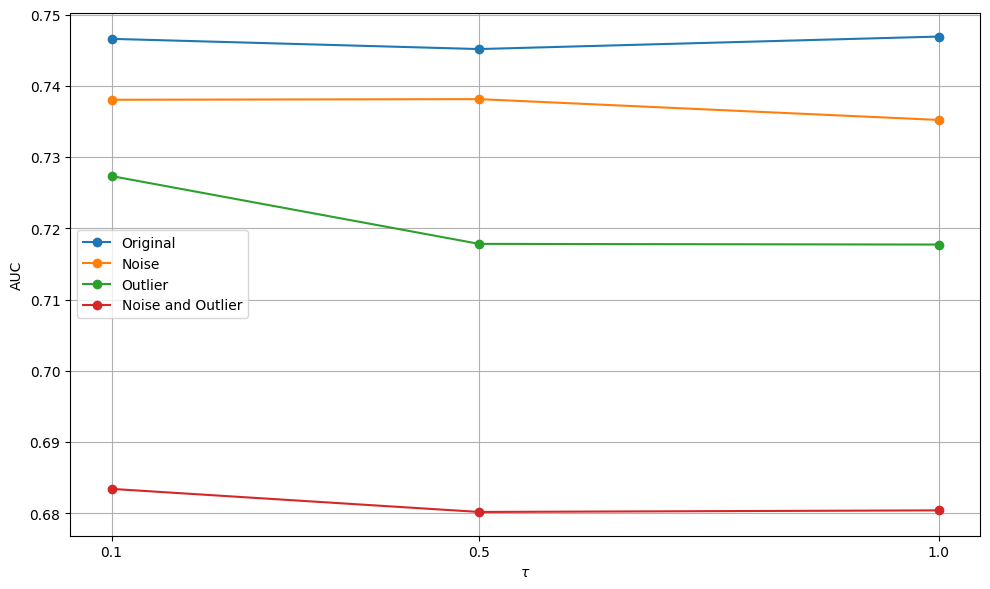

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import time
import warnings
import csv
import matplotlib.pyplot as plt
from joblib import parallel_backend
import multiprocessing
warnings.filterwarnings("ignore")

# Số lượng core có sẵn để parallel processing
n_cores = multiprocessing.cpu_count()

# Danh sách các file dữ liệu
file_names = [
    'diabetes.csv',
    'diabetes_noise_label_feature.csv',
    'diabetes_outlier.csv',
    "diabetes_both_noise_outlier.csv"
]
print('Model: Pin-FS-SVM')
results = []
max_time_per_file = 30 * 60  # 30 phút

# Khởi tạo figure và axes cho các biểu đồ
fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False)
axs = axs.ravel()
plot_index = 0

for iteration, file_name in enumerate(file_names):
    print(f"\nXử lý file: {file_name}")
    if iteration == 0:
        print('Not noise')
        noise_type = 'Original'
    elif iteration == 1:
        print('Noise')
        noise_type = 'Noise'
    elif iteration == 2:
        print('Outlier')
        noise_type = 'Outlier'
    else:
        noise_type = 'Noise and Outlier'
    df = pd.read_csv(file_name)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    # Chuyển đổi nhãn từ 0/1 thành -1/1
    y = np.where(y == 0, -1, 1)


    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()

    # Các tham số của mô hình
    l = [-2] * X.shape[1]
    u = [2] * X.shape[1]
    C_values = [2**i for i in range(-3, 6)]
    tau_values = [0.1, 0.5, 1]
    best_B = None
    best_C = None
    best_tau = None
    best_mean_cv_accuracy = 0
    best_mean_cv_AUC = 0
    no_improvement_count = 0

    n = X.shape[1]
    B_values = [i for i in range(1, n+1)]

    start_file_time = time.time()
    dataset_tau_auc = {}
    with parallel_backend('loky', n_jobs=n_cores):
      for tau in tau_values:
          best_mean_cv_AUC_for_tau = 0
          for C in C_values:
            for B in B_values:
              kf = KFold(n_splits=10, shuffle=True, random_state=42)
              cv_accuracies = []
              cv_AUC = []
              cv_times = []

              for train_index, val_index in kf.split(X):
                  start_time = time.time()
                  X_cv_train, X_cv_val = X[train_index], X[val_index]
                  y_cv_train, y_cv_val = y[train_index], y[val_index]

                  # Chuẩn hóa dữ liệu
                  X_cv_train = scaler.fit_transform(X_cv_train)
                  X_cv_val = scaler.transform(X_cv_val)

                  # Khởi tạo mô hình
                  opt_mod = Model(name='Pin-FS-SVM')
                  m, n = X_cv_train.shape

                  # Các biến quyết định
                  w = opt_mod.continuous_var_list(n, name='w')
                  b = opt_mod.continuous_var(name='b')
                  v = opt_mod.binary_var_list(n, name='v')
                  xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
                  z = opt_mod.continuous_var_list(n, lb=0, name='z')

                  # Hàm mục tiêu
                  opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))

                  # Ràng buộc phân loại
                  for i in range(m):
                      opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) >= 1 - xi[i])
                      opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau))

                  # Ràng buộc tổng các đặc trưng được chọn
                  opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)

                  # Ràng buộc cho w_j^+ và w_j^-
                  for j in range(n):
                      opt_mod.add_constraint(w[j] <= v[j] * u[j])
                      opt_mod.add_constraint(w[j] >= l[j] * v[j])
                      opt_mod.add_constraint(w[j] <= z[j])
                      opt_mod.add_constraint(w[j] >= -z[j])

                  # Giải mô hình
                  solution = opt_mod.solve()

                  end_time = time.time()
                  fold_time = end_time - start_time
                  cv_times.append(fold_time)

                  if solution:
                      w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                      b_opt = solution.get_value('b')
                      v_opt = np.array([solution.get_value(f'v_{j}') for j in range(n)])
                      y_cv_pred = np.sign(np.dot(X_cv_val, w_opt) + b_opt)
                      cv_accuracy = accuracy_score(y_cv_val, y_cv_pred)
                      cv_auc = roc_auc_score(y_cv_val, y_cv_pred)
                      cv_accuracies.append(cv_accuracy)
                      cv_AUC.append(cv_auc)
                  else:
                      print("Solution not found for fold.")

              # Đánh giá trung bình trên tập huấn luyện bằng 10-fold cross-validation với mỗi giá trị B
              mean_cv_accuracy = np.mean(cv_accuracies)
              mean_cv_AUC = np.mean(cv_AUC)
              mean_time_per_fold = np.mean(cv_times)
              
              # Kiểm tra điều kiện early stopping
              if mean_cv_AUC > best_mean_cv_AUC_for_tau:
                  best_B_for_tau = B
                  best_C_for_tau = C
                  best_mean_cv_accuracy_for_tau = mean_cv_accuracy
                  best_mean_cv_AUC_for_tau = mean_cv_AUC
                  best_mean_time_per_fold_for_tau = mean_time_per_fold
                  best_w_for_tau = w_opt
                  best_b_for_tau = b_opt
                  best_v_for_tau = v_opt
          dataset_tau_auc[tau] = best_mean_cv_AUC_for_tau
          if best_mean_cv_AUC_for_tau > best_mean_cv_AUC:
              best_B = best_B_for_tau
              best_C = best_C_for_tau
              best_tau = tau
              best_mean_cv_accuracy = best_mean_cv_accuracy_for_tau
              best_mean_cv_AUC = best_mean_cv_AUC_for_tau
              best_mean_time_per_fold = best_mean_time_per_fold_for_tau
              best_w = best_w_for_tau
              best_b = best_b_for_tau
              best_v = best_v_for_tau
                
              
    print(f'Best B value: {best_B}')
    print(f'Best C: {best_C}')
    print(f'Best tau: {best_tau}')
    print(f'Best Accuracy on 10-CV: {best_mean_cv_accuracy}')
    print(f'Best AUC on 10-CV:  {best_mean_cv_AUC}')
    print(f'Average time per fold: {best_mean_time_per_fold:.2f} seconds')

    selected_features = [j + 1 for j in range(n) if best_w[j] != 0]

    print(f'v: {best_v}')
    print(f'Features selected: {selected_features}')
    print(f'Number of selected features: {len(selected_features)}')
    print('-' * 100)
    result = {
            'Model': 'Pin-FS-SVM',  # Thay đổi tên mô hình tương ứng
            'Type of model': noise_type,
            'Accuracy': best_mean_cv_accuracy,
            'AUC': best_mean_cv_AUC,
            'Time': best_mean_time_per_fold,
            'Features selected': ', '.join(map(str, selected_features)),
            'Number of features': len(selected_features),
            'C': best_C,
            'tau': best_tau
        }
    results.append(result)
    # Vẽ line chart
    axs[0].plot(list(dataset_tau_auc.keys()), list(dataset_tau_auc.values()), label=f'{noise_type}', marker='o')


# Cấu hình biểu đồ
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('AUC')
# axs[0].set_title('Average AUC vs. Tau for each dataset')
axs[0].legend()
axs[0].set_xticks(tau_values)
axs[0].grid(True)
plt.tight_layout()
plt.show()
# Sau khi chạy xong tất cả các mô hình, thêm đoạn code sau để in ra file CSV
# output_file = 'v2_model_results_diabetes.csv'
# fieldnames = ['Model', 'Type of model', 'Accuracy', 'AUC', 'Time', 'Features selected', 'Number of features', 'C', 'tau']

# with open(output_file, mode='a', newline='', encoding='utf-8') as file:
#     writer = csv.DictWriter(file, fieldnames=fieldnames)
#     writer.writeheader()
#     for result in results:
#         writer.writerow(result)

# print(f"Kết quả đã được lưu vào file {output_file}")

# Cleveland

Model: Pin-FS-SVM

Xử lý file: Heart_disease_cleveland_new.csv
Not noise


Best B value: 6
Best C: 16
Best tau: 0.1
Best Accuracy on 10-CV: 0.8479569892473119
Best AUC on 10-CV:  0.8422792822502576
Average time per fold: 0.11 seconds
v: [0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
Features selected: [2, 3, 9, 11, 12, 13]
Number of selected features: 6
----------------------------------------------------------------------------------------------------

Xử lý file: clevaland_noise_label_feature.csv
Noise
Best B value: 4
Best C: 2
Best tau: 0.1
Best Accuracy on 10-CV: 0.8017204301075269
Best AUC on 10-CV:  0.7964801334286629
Average time per fold: 0.11 seconds
v: [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
Features selected: [3, 10, 12, 13]
Number of selected features: 4
----------------------------------------------------------------------------------------------------

Xử lý file: clevaland_outlier.csv
Outlier
Best B value: 7
Best C: 1
Best tau: 0.1
Best Accuracy on 10-CV: 0.7886021505376343
Best AUC on 10-CV:  0.7868007781262426
Average time per fold: 0.09 seconds
v

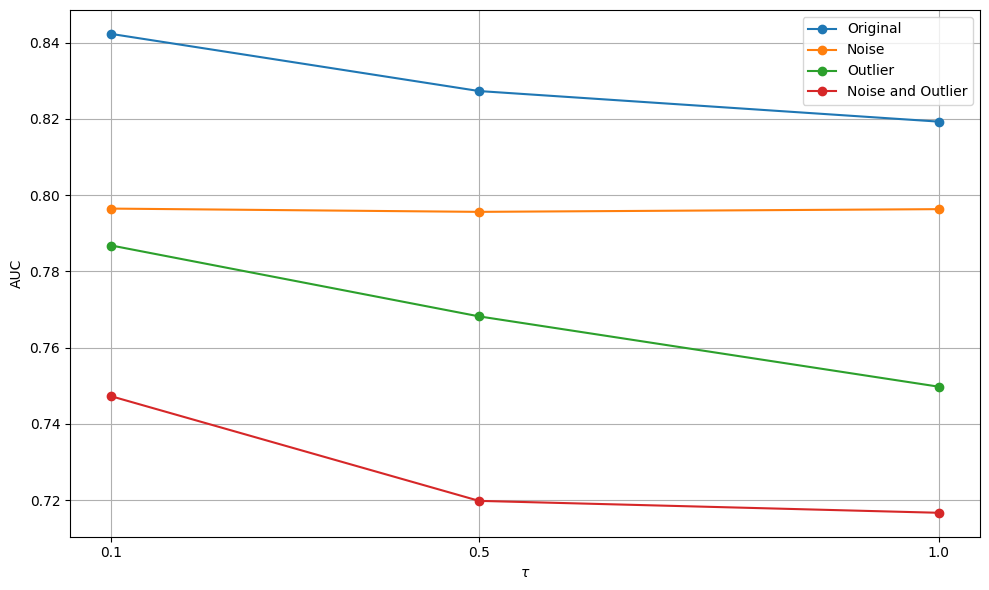

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import time
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

# Danh sách các file dữ liệu
file_names = [
    'Heart_disease_cleveland_new.csv',
    'clevaland_noise_label_feature.csv',
    'clevaland_outlier.csv',
    'cleveland_both_noise_outlier.csv'
]
print('Model: Pin-FS-SVM')
results = []
max_time_per_file = 30 * 60  # 30 phút
dataset_tau_auc = {}
# Khởi tạo figure và axes cho các biểu đồ
fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False)
axs = axs.ravel()
plot_index = 0
# no_improvement_limit = 5  # Số lần lặp không cải thiện AUC

for iteration, file_name in enumerate(file_names):
    print(f"\nXử lý file: {file_name}")
    if iteration == 0: 
        print('Not noise')
        noise_type = 'Original'
    elif iteration == 1:
        print('Noise')
        noise_type = 'Noise'
    elif iteration == 2:
        print('Outlier')
        noise_type = 'Outlier'
    else:
        noise_type = 'Noise and Outlier'
    
    df = pd.read_csv(file_name, header=None)
    

    X = df.iloc[1:,0:13].values
    X = X.astype(float)
    y = df.iloc[1:, 13].values
    y = y.astype(float)
    y = np.where(y == 0 , -1 , y)


    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()

    # Các tham số của mô hình
    l = [-4] * X.shape[1]
    u = [4] * X.shape[1]
    C_values = [2**i for i in range(-3, 6)]
    tau_values = [0.1, 0.5, 1]

    best_B = None
    best_mean_cv_accuracy = 0
    best_mean_cv_AUC = 0
    no_improvement_count = 0

    n = X.shape[1]
    B_values = [i for i in range(1, n+1)]

    start_file_time = time.time()

    with parallel_backend('loky', n_jobs=n_cores):
        for tau in tau_values:
            best_mean_cv_AUC_for_tau = 0
            for C in C_values:
                for B in B_values:
                    kf = KFold(n_splits=10, shuffle=True, random_state= 1)
                    cv_accuracies = []
                    cv_AUC = []
                    cv_times = []

                    for train_index, val_index in kf.split(X):
                        start_time = time.time()
                        X_cv_train, X_cv_val = X[train_index], X[val_index]
                        y_cv_train, y_cv_val = y[train_index], y[val_index]

                        # Chuẩn hóa dữ liệu
                        X_cv_train = scaler.fit_transform(X_cv_train)
                        X_cv_val = scaler.transform(X_cv_val)

                        # Khởi tạo mô hình
                        opt_mod = Model(name='Pin-FS-SVM')
                        m, n = X_cv_train.shape

                        # Các biến quyết định
                        w = opt_mod.continuous_var_list(n, name='w')
                        b = opt_mod.continuous_var(name='b')
                        v = opt_mod.binary_var_list(n, name='v')
                        xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
                        z = opt_mod.continuous_var_list(n, lb=0, name='z')

                        # Hàm mục tiêu
                        opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))

                        # Ràng buộc phân loại
                        for i in range(m):
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) >= 1 - xi[i])
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau))

                        # Ràng buộc tổng các đặc trưng được chọn
                        opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)

                        # Ràng buộc cho w_j^+ và w_j^-
                        for j in range(n):
                            opt_mod.add_constraint(w[j] <= v[j] * u[j])
                            opt_mod.add_constraint(w[j] >= l[j] * v[j])
                            opt_mod.add_constraint(w[j] <= z[j])
                            opt_mod.add_constraint(w[j] >= -z[j])

                        # Giải mô hình
                        solution = opt_mod.solve()

                        end_time = time.time()
                        fold_time = end_time - start_time
                        cv_times.append(fold_time)

                        if solution:
                            w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                            b_opt = solution.get_value('b')
                            v_opt = np.array([solution.get_value(f'v_{j}') for j in range(n)])
                            y_cv_pred = np.sign(np.dot(X_cv_val, w_opt) + b_opt)
                            cv_accuracy = accuracy_score(y_cv_val, y_cv_pred)
                            cv_auc = roc_auc_score(y_cv_val, y_cv_pred)
                            cv_accuracies.append(cv_accuracy)
                            cv_AUC.append(cv_auc)
                        else:
                            print("Solution not found for fold.")

                    # Đánh giá trung bình trên tập huấn luyện bằng 10-fold cross-validation với mỗi giá trị B
                    mean_cv_accuracy = np.mean(cv_accuracies)
                    mean_cv_AUC = np.mean(cv_AUC)
                    mean_time_per_fold = np.mean(cv_times)
                    
                    # Kiểm tra điều kiện early stopping
                    if mean_cv_AUC > best_mean_cv_AUC_for_tau:
                        best_B_for_tau = B
                        best_C_for_tau = C
                        best_mean_cv_accuracy_for_tau = mean_cv_accuracy
                        best_mean_cv_AUC_for_tau = mean_cv_AUC
                        best_mean_time_per_fold_for_tau = mean_time_per_fold
                        best_w_for_tau = w_opt
                        best_b_for_tau = b_opt
                        best_v_for_tau = v_opt
                dataset_tau_auc[tau] = best_mean_cv_AUC_for_tau
                if best_mean_cv_AUC_for_tau > best_mean_cv_AUC:
                    best_B = best_B_for_tau
                    best_C = best_C_for_tau
                    best_tau = tau
                    best_mean_cv_accuracy = best_mean_cv_accuracy_for_tau
                    best_mean_cv_AUC = best_mean_cv_AUC_for_tau
                    best_mean_time_per_fold = best_mean_time_per_fold_for_tau
                    best_w = best_w_for_tau
                    best_b = best_b_for_tau
                    best_v = best_v_for_tau
                    
              
    print(f'Best B value: {best_B}')
    print(f'Best C: {best_C}')
    print(f'Best tau: {best_tau}')
    print(f'Best Accuracy on 10-CV: {best_mean_cv_accuracy}')
    print(f'Best AUC on 10-CV:  {best_mean_cv_AUC}')
    print(f'Average time per fold: {best_mean_time_per_fold:.2f} seconds')

    selected_features = [j + 1 for j in range(n) if best_w[j] != 0]

    print(f'v: {best_v}')
    print(f'Features selected: {selected_features}')
    print(f'Number of selected features: {len(selected_features)}')
    print('-' * 100)
    result = {
            'Model': 'Pin-FS-SVM',  # Thay đổi tên mô hình tương ứng
            'Type of model': noise_type,
            'Accuracy': best_mean_cv_accuracy,
            'AUC': best_mean_cv_AUC,
            'Time': best_mean_time_per_fold,
            'Features selected': ', '.join(map(str, selected_features)),
            'Number of features': len(selected_features),
            'C': best_C,
            'tau': best_tau
        }
    results.append(result)
    # Vẽ line chart
    axs[0].plot(list(dataset_tau_auc.keys()), list(dataset_tau_auc.values()), label=f'{noise_type}', marker='o')


# Cấu hình biểu đồ
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('AUC')
# axs[0].set_title('Average AUC vs. Tau for each dataset')
axs[0].legend()
axs[0].set_xticks(tau_values)
axs[0].grid(True)
plt.tight_layout()
plt.show()

# Sonar

Số lõi CPU có sẵn: 20
Model: Pin-FS-SVM

Xử lý file: sonar.txt
Not noise


Best B value: 8
Best C: 0.25
Best tau: 0.5
Best Accuracy on 10-CV: 0.7738095238095238
Best AUC on 10-CV:  0.7802317127317128
Average time per fold: 0.24 seconds
v: [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Features selected: [4, 9, 12, 20, 26, 29, 47, 49]
Number of selected features: 8
----------------------------------------------------------------------------------------------------

Xử lý file: sonar_noise_label_feature.txt
Noise
Best B value: 5
Best C: 2
Best tau: 0.5
Best Accuracy on 10-CV: 0.7592857142857142
Best AUC on 10-CV:  0.7664506327006327
Average time per fold: 0.64 seconds
v: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Features selected: [12, 21, 44, 49, 60]
Number of selected features: 5
-----

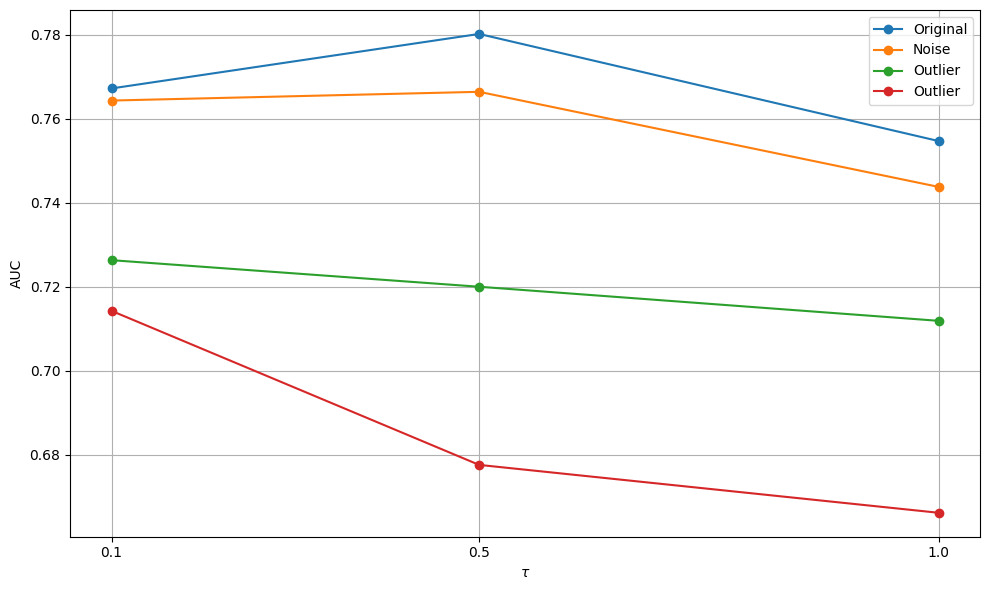

In [10]:
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import time
import multiprocessing
from joblib import parallel_backend
import warnings
warnings.filterwarnings("ignore")

n_cores = multiprocessing.cpu_count()
print(f"Số lõi CPU có sẵn: {n_cores}")

# Danh sách các file dữ liệu
file_names = [
    'sonar.txt',
    'sonar_noise_label_feature.txt',
    'sonar_outlier.txt',
    'sonar_both_noise_outlier.txt'
]

print('Model: Pin-FS-SVM')
results = []
max_time_per_file = 30 * 60  # 30 phút
dataset_tau_auc = {}
# Khởi tạo figure và axes cho các biểu đồ
fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False)
axs = axs.ravel()
plot_index = 0
# no_improvement_limit = 5  # Số lần lặp không cải thiện AUC

for iteration, file_name in enumerate(file_names):
    print(f"\nXử lý file: {file_name}")
    if iteration == 0: 
        print('Not noise')
        noise_type = 'Original'
    elif iteration == 1:
        print('Noise')
        noise_type = 'Noise'
    elif iteration == 2:
        print('Outlier')
        noise_type = 'Outlier'
    else:
        noise_type == 'Noise and Outlier'
    
    df = pd.read_csv(file_name, header=None)

    X = df.iloc[:, 0:60].values
    y = df .iloc[:,60].values
    # Chuyển đổi nhãn từ B/M thành -1/1
    y = np.where(y == 'M', 1, -1)

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()

    # Các tham số của mô hình
    l = [-2] * X.shape[1]
    u = [2] * X.shape[1]
    C_values = [2**i for i in range(-3, 6)]
    tau_values = [0.1, 0.5, 1]

    best_B = None
    best_mean_cv_accuracy = 0
    best_mean_cv_AUC = 0
    no_improvement_count = 0

    n = X.shape[1]
    B_values = [i for i in range(1, n+1)]

    start_file_time = time.time()

    with parallel_backend('loky', n_jobs=n_cores):
        for tau in tau_values:
            best_mean_cv_AUC_for_tau = 0
            for C in C_values:
                for B in B_values:
                    kf = KFold(n_splits=10, shuffle=True, random_state=42)
                    cv_accuracies = []
                    cv_AUC = []
                    cv_times = []

                    for train_index, val_index in kf.split(X):
                        start_time = time.time()
                        X_cv_train, X_cv_val = X[train_index], X[val_index]
                        y_cv_train, y_cv_val = y[train_index], y[val_index]

                        # Chuẩn hóa dữ liệu
                        X_cv_train = scaler.fit_transform(X_cv_train)
                        X_cv_val = scaler.transform(X_cv_val)

                        # Khởi tạo mô hình
                        opt_mod = Model(name='Pin-FS-SVM')
                        m, n = X_cv_train.shape

                        # Các biến quyết định
                        w = opt_mod.continuous_var_list(n, name='w')
                        b = opt_mod.continuous_var(name='b')
                        v = opt_mod.binary_var_list(n, name='v')
                        xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
                        z = opt_mod.continuous_var_list(n, lb=0, name='z')

                        # Hàm mục tiêu
                        opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))

                        # Ràng buộc phân loại
                        for i in range(m):
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) >= 1 - xi[i])
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau))

                        # Ràng buộc tổng các đặc trưng được chọn
                        opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)

                        # Ràng buộc cho w_j^+ và w_j^-
                        for j in range(n):
                            opt_mod.add_constraint(w[j] <= v[j] * u[j])
                            opt_mod.add_constraint(w[j] >= l[j] * v[j])
                            opt_mod.add_constraint(w[j] <= z[j])
                            opt_mod.add_constraint(w[j] >= -z[j])

                        # Giải mô hình
                        solution = opt_mod.solve()

                        end_time = time.time()
                        fold_time = end_time - start_time
                        cv_times.append(fold_time)

                        if solution:
                            w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                            b_opt = solution.get_value('b')
                            v_opt = np.array([solution.get_value(f'v_{j}') for j in range(n)])
                            y_cv_pred = np.sign(np.dot(X_cv_val, w_opt) + b_opt)
                            cv_accuracy = accuracy_score(y_cv_val, y_cv_pred)
                            cv_auc = roc_auc_score(y_cv_val, y_cv_pred)
                            cv_accuracies.append(cv_accuracy)
                            cv_AUC.append(cv_auc)
                        else:
                            print("Solution not found for fold.")

                    # Đánh giá trung bình trên tập huấn luyện bằng 10-fold cross-validation với mỗi giá trị B
                    mean_cv_accuracy = np.mean(cv_accuracies)
                    mean_cv_AUC = np.mean(cv_AUC)
                    mean_time_per_fold = np.mean(cv_times)
                    
                    # Kiểm tra điều kiện early stopping
                    if mean_cv_AUC > best_mean_cv_AUC_for_tau:
                        best_B_for_tau = B
                        best_C_for_tau = C
                        best_mean_cv_accuracy_for_tau = mean_cv_accuracy
                        best_mean_cv_AUC_for_tau = mean_cv_AUC
                        best_mean_time_per_fold_for_tau = mean_time_per_fold
                        best_w_for_tau = w_opt
                        best_b_for_tau = b_opt
                        best_v_for_tau = v_opt
                dataset_tau_auc[tau] = best_mean_cv_AUC_for_tau
                if best_mean_cv_AUC_for_tau > best_mean_cv_AUC:
                    best_B = best_B_for_tau
                    best_C = best_C_for_tau
                    best_tau = tau
                    best_mean_cv_accuracy = best_mean_cv_accuracy_for_tau
                    best_mean_cv_AUC = best_mean_cv_AUC_for_tau
                    best_mean_time_per_fold = best_mean_time_per_fold_for_tau
                    best_w = best_w_for_tau
                    best_b = best_b_for_tau
                    best_v = best_v_for_tau
                    
              
    print(f'Best B value: {best_B}')
    print(f'Best C: {best_C}')
    print(f'Best tau: {best_tau}')
    print(f'Best Accuracy on 10-CV: {best_mean_cv_accuracy}')
    print(f'Best AUC on 10-CV:  {best_mean_cv_AUC}')
    print(f'Average time per fold: {best_mean_time_per_fold:.2f} seconds')

    selected_features = [j + 1 for j in range(n) if best_w[j] != 0]

    print(f'v: {best_v}')
    print(f'Features selected: {selected_features}')
    print(f'Number of selected features: {len(selected_features)}')
    print('-' * 100)
    result = {
            'Model': 'Pin-FS-SVM',  # Thay đổi tên mô hình tương ứng
            'Type of model': noise_type,
            'Accuracy': best_mean_cv_accuracy,
            'AUC': best_mean_cv_AUC,
            'Time': best_mean_time_per_fold,
            'Features selected': ', '.join(map(str, selected_features)),
            'Number of features': len(selected_features),
            'C': best_C,
            'tau': best_tau
        }
    results.append(result)
    # Vẽ line chart
    axs[0].plot(list(dataset_tau_auc.keys()), list(dataset_tau_auc.values()), label=f'{noise_type}', marker='o')


# Cấu hình biểu đồ
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('AUC')
# axs[0].set_title('Average AUC vs. Tau for each dataset')
axs[0].legend()
axs[0].set_xticks(tau_values)
axs[0].grid(True)
plt.tight_layout()
plt.show()

# Australia

Model: MILP1

Xử lý file: australia.txt
Not noise


Best B value: 1
Best C: 0.125
Best tau: 0.1
Best Accuracy on 10-CV: 0.855072463768116
Best AUC on 10-CV:  0.8578515743847543
Average time per fold: 0.13 seconds
v: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Features selected: [8]
Number of selected features: 1
----------------------------------------------------------------------------------------------------

Xử lý file: australia_noise_label_feature.txt
Noise
Best B value: 1
Best C: 0.125
Best tau: 0.1
Best Accuracy on 10-CV: 0.8144927536231885
Best AUC on 10-CV:  0.8162975120891316
Average time per fold: 0.15 seconds
v: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Features selected: [8]
Number of selected features: 1
----------------------------------------------------------------------------------------------------

Xử lý file: australia_outlier.txt
Outlier
Best B value: 1
Best C: 0.125
Best tau: 0.1
Best Accuracy on 10-CV: 0.808695652173913
Best AUC on 10-CV:  0.8239706182015019
Average time per fold: 0.13 seconds
v: [0. 0. 0. 0. 

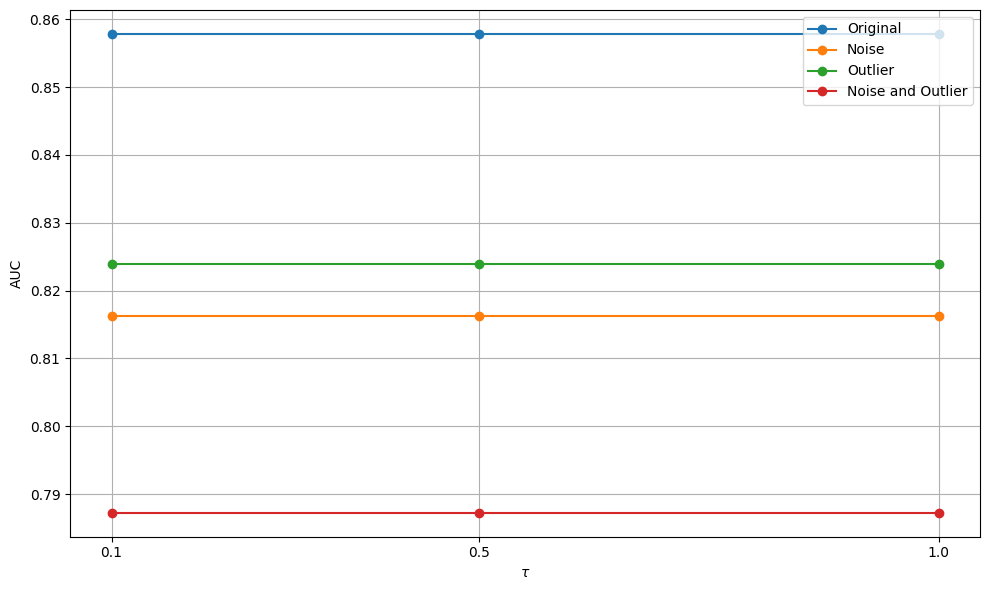

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import time
import warnings
from joblib import parallel_backend
import warnings
warnings.filterwarnings("ignore")

# Danh sách các file dữ liệu
file_names = [
    "australia.txt",
    "australia_noise_label_feature.txt",
    "australia_outlier.txt",
    'australia_both_noise_outlier.txt'
]
print('Model: Pin-FS-SVM')
results = []
dataset_tau_auc = {}
# Khởi tạo figure và axes cho các biểu đồ
fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False)
axs = axs.ravel()
plot_index = 0
# Tạo danh sách để lưu kết quả
for iteration, file_name in enumerate(file_names):
    
    print(f"\nXử lý file: {file_name}")
    if iteration == 0: 
        print('Not noise')
        noise_type = 'Original'
        df = pd.read_csv(file_name, header= None, sep = ' ')
    elif iteration == 1:
        print('Noise')
        noise_type = 'Noise'
        df = pd.read_csv(file_name, header= None)
    elif iteration == 2:
        print('Outlier')
        noise_type = 'Outlier'
        df = pd.read_csv(file_name, header= None)
    else:
        noise_type = 'Noise and Outlier'
        df = pd.read_csv(file_name, header= None)
    
    # df = pd.read_csv(file_name, header= None)

    X = df.iloc[:,:14].values
    y = df.iloc[:,14].values
    y = np.where(y == 0, -1, y)

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()

    # Các tham số của mô hình
    l = [-2] * X.shape[1]
    u = [2] * X.shape[1]
    C_values = [2**i for i in range(-3, 6)]
    tau_values = [0.1, 0.5, 1]

    best_B = None
    best_mean_cv_accuracy = 0
    best_mean_cv_AUC = 0
    no_improvement_count = 0

    n = X.shape[1]
    B_values = [i for i in range(1, n+1)]

    start_file_time = time.time()


    with parallel_backend('loky', n_jobs=n_cores):
        for tau in tau_values:
            best_mean_cv_AUC_for_tau = 0
            for C in C_values:
                for B in B_values:
                    kf = KFold(n_splits=10, shuffle=True, random_state=42)
                    cv_accuracies = []
                    cv_AUC = []
                    cv_times = []

                    for train_index, val_index in kf.split(X):
                        start_time = time.time()
                        X_cv_train, X_cv_val = X[train_index], X[val_index]
                        y_cv_train, y_cv_val = y[train_index], y[val_index]

                        # Chuẩn hóa dữ liệu
                        X_cv_train = scaler.fit_transform(X_cv_train)
                        X_cv_val = scaler.transform(X_cv_val)

                        # Khởi tạo mô hình
                        opt_mod = Model(name='Pin-FS-SVM')
                        m, n = X_cv_train.shape

                        # Các biến quyết định
                        w = opt_mod.continuous_var_list(n, name='w')
                        b = opt_mod.continuous_var(name='b')
                        v = opt_mod.binary_var_list(n, name='v')
                        xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
                        z = opt_mod.continuous_var_list(n, lb=0, name='z')

                        # Hàm mục tiêu
                        opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))

                        # Ràng buộc phân loại
                        for i in range(m):
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) >= 1 - xi[i])
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau))

                        # Ràng buộc tổng các đặc trưng được chọn
                        opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)

                        # Ràng buộc cho w_j^+ và w_j^-
                        for j in range(n):
                            opt_mod.add_constraint(w[j] <= v[j] * u[j])
                            opt_mod.add_constraint(w[j] >= l[j] * v[j])
                            opt_mod.add_constraint(w[j] <= z[j])
                            opt_mod.add_constraint(w[j] >= -z[j])

                        # Giải mô hình
                        solution = opt_mod.solve()

                        end_time = time.time()
                        fold_time = end_time - start_time
                        cv_times.append(fold_time)

                        if solution:
                            w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                            b_opt = solution.get_value('b')
                            v_opt = np.array([solution.get_value(f'v_{j}') for j in range(n)])
                            y_cv_pred = np.sign(np.dot(X_cv_val, w_opt) + b_opt)
                            cv_accuracy = accuracy_score(y_cv_val, y_cv_pred)
                            cv_auc = roc_auc_score(y_cv_val, y_cv_pred)
                            cv_accuracies.append(cv_accuracy)
                            cv_AUC.append(cv_auc)
                        else:
                            print("Solution not found for fold.")

                    # Đánh giá trung bình trên tập huấn luyện bằng 10-fold cross-validation với mỗi giá trị B
                    mean_cv_accuracy = np.mean(cv_accuracies)
                    mean_cv_AUC = np.mean(cv_AUC)
                    mean_time_per_fold = np.mean(cv_times)
                    
                    # Kiểm tra điều kiện early stopping
                    if mean_cv_AUC > best_mean_cv_AUC_for_tau:
                        best_B_for_tau = B
                        best_C_for_tau = C
                        best_mean_cv_accuracy_for_tau = mean_cv_accuracy
                        best_mean_cv_AUC_for_tau = mean_cv_AUC
                        best_mean_time_per_fold_for_tau = mean_time_per_fold
                        best_w_for_tau = w_opt
                        best_b_for_tau = b_opt
                        best_v_for_tau = v_opt
                dataset_tau_auc[tau] = best_mean_cv_AUC_for_tau
                if best_mean_cv_AUC_for_tau > best_mean_cv_AUC:
                    best_B = best_B_for_tau
                    best_C = best_C_for_tau
                    best_tau = tau
                    best_mean_cv_accuracy = best_mean_cv_accuracy_for_tau
                    best_mean_cv_AUC = best_mean_cv_AUC_for_tau
                    best_mean_time_per_fold = best_mean_time_per_fold_for_tau
                    best_w = best_w_for_tau
                    best_b = best_b_for_tau
                    best_v = best_v_for_tau
                    
              
    print(f'Best B value: {best_B}')
    print(f'Best C: {best_C}')
    print(f'Best tau: {best_tau}')
    print(f'Best Accuracy on 10-CV: {best_mean_cv_accuracy}')
    print(f'Best AUC on 10-CV:  {best_mean_cv_AUC}')
    print(f'Average time per fold: {best_mean_time_per_fold:.2f} seconds')

    selected_features = [j + 1 for j in range(n) if best_w[j] != 0]

    print(f'v: {best_v}')
    print(f'Features selected: {selected_features}')
    print(f'Number of selected features: {len(selected_features)}')
    print('-' * 100)
    result = {
            'Model': 'Pin-FS-SVM',  # Thay đổi tên mô hình tương ứng
            'Type of model': noise_type,
            'Accuracy': best_mean_cv_accuracy,
            'AUC': best_mean_cv_AUC,
            'Time': best_mean_time_per_fold,
            'Features selected': ', '.join(map(str, selected_features)),
            'Number of features': len(selected_features),
            'C': best_C,
            'tau': best_tau
        }
    results.append(result)
    # Vẽ line chart
    axs[0].plot(list(dataset_tau_auc.keys()), list(dataset_tau_auc.values()), label=f'{noise_type}', marker='o')


# Cấu hình biểu đồ
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('AUC')
# axs[0].set_title('Performance with different $\\tau$ values of Pin-FS-SVM for each dataset')
axs[0].legend()
axs[0].set_xticks(tau_values)
axs[0].grid(True)
plt.tight_layout()
plt.show()

# Ionosphere

Số lõi CPU có sẵn: 4
Model: Pin-FS-SVM

Xử lý file: ionosphere.data
Not noise


FileNotFoundError: [Errno 2] No such file or directory: 'ionosphere.data'

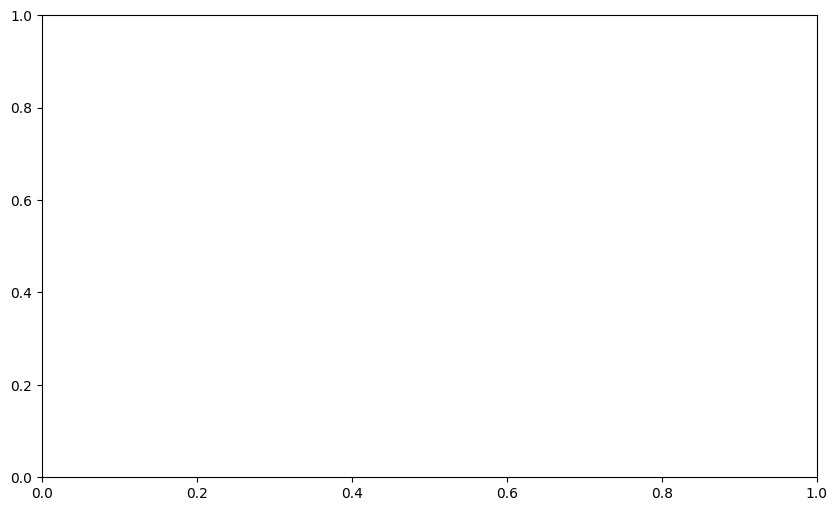

In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import time
import multiprocessing
from joblib import parallel_backend
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 

n_cores = multiprocessing.cpu_count()
print(f"Số lõi CPU có sẵn: {n_cores}")

# Danh sách các file dữ liệu
file_names = [
    'ionosphere.data',
    'ionosphere_noise_label_feature.txt',
    'ionosphere_outlier.txt',
    "ionosphere_both_noise_outlier.txt"
]

print('Model: Pin-FS-SVM')
results = []
max_time_per_file = 60 * 60  # 30 phút
# Khởi tạo figure và axes cho các biểu đồ
fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False)
axs = axs.ravel()
plot_index = 0
dataset_tau_auc = {}
for iteration, file_name in enumerate(file_names):
    print(f"\nXử lý file: {file_name}")
    if iteration == 0: 
        print('Not noise')
        noise_type = 'Original'
    elif iteration == 1:
        print('Noise')
        noise_type = 'Noise'
    elif iteration == 2:
        print('Outlier')
        noise_type = 'Outlier'
    else:
        noise_type = 'Noise and Outlier'
    
    df = pd.read_csv(file_name, header=None)

    # Tách dữ liệu và nhãn
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    # Chuyển đổi nhãn từ B/M thành -1/1
    y = np.where(y == 'g', 1, -1)

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()

    # Các tham số của mô hình
    l = [-2] * X.shape[1]
    u = [2] * X.shape[1]
    C_values = [2**i for i in range(-3, 6)]
    tau_values = [0.1, 0.5, 1]

    best_B = None
    best_mean_cv_accuracy = 0
    best_mean_cv_AUC = 0
    no_improvement_count = 0
    dataset_tau_auc = {}

    n = X.shape[1]
    B_values = [i for i in range(1, n+1)]

    start_file_time = time.time()

    with parallel_backend('loky', n_jobs=n_cores):
        for tau in tau_values:
            best_mean_cv_AUC_for_tau = 0
            for C in C_values:
                for B in B_values:
                    current_time = time.time()
                    if current_time - start_file_time > max_time_per_file:
                        break
                    kf = KFold(n_splits=10, shuffle=True, random_state=42)
                    cv_accuracies = []
                    cv_AUC = []
                    cv_times = []

                    for train_index, val_index in kf.split(X):
                        start_time = time.time()
                        X_cv_train, X_cv_val = X[train_index], X[val_index]
                        y_cv_train, y_cv_val = y[train_index], y[val_index]

                        # Chuẩn hóa dữ liệu
                        X_cv_train = scaler.fit_transform(X_cv_train)
                        X_cv_val = scaler.transform(X_cv_val)

                        # Khởi tạo mô hình
                        opt_mod = Model(name='Pin-FS-SVM')
                        m, n = X_cv_train.shape

                        # Các biến quyết định
                        w = opt_mod.continuous_var_list(n, name='w')
                        b = opt_mod.continuous_var(name='b')
                        v = opt_mod.binary_var_list(n, name='v')
                        xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
                        z = opt_mod.continuous_var_list(n, lb=0, name='z')

                        # Hàm mục tiêu
                        opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))

                        # Ràng buộc phân loại
                        for i in range(m):
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) >= 1 - xi[i])
                            opt_mod.add_constraint(y_cv_train[i] * (opt_mod.sum(w[j] * X_cv_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau))

                        # Ràng buộc tổng các đặc trưng được chọn
                        opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)

                        # Ràng buộc cho w_j^+ và w_j^-
                        for j in range(n):
                            opt_mod.add_constraint(w[j] <= v[j] * u[j])
                            opt_mod.add_constraint(w[j] >= l[j] * v[j])
                            opt_mod.add_constraint(w[j] <= z[j])
                            opt_mod.add_constraint(w[j] >= -z[j])

                        # Giải mô hình
                        solution = opt_mod.solve()

                        end_time = time.time()
                        fold_time = end_time - start_time
                        cv_times.append(fold_time)

                        if solution:
                            w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                            b_opt = solution.get_value('b')
                            v_opt = np.array([solution.get_value(f'v_{j}') for j in range(n)])
                            y_cv_pred = np.sign(np.dot(X_cv_val, w_opt) + b_opt)
                            cv_accuracy = accuracy_score(y_cv_val, y_cv_pred)
                            cv_auc = roc_auc_score(y_cv_val, y_cv_pred)
                            cv_accuracies.append(cv_accuracy)
                            cv_AUC.append(cv_auc)
                        else:
                            print("Solution not found for fold.")

                    # Đánh giá trung bình trên tập huấn luyện bằng 10-fold cross-validation với mỗi giá trị B
                    mean_cv_accuracy = np.mean(cv_accuracies)
                    mean_cv_AUC = np.mean(cv_AUC)
                    mean_time_per_fold = np.mean(cv_times)
                    
                    # Kiểm tra điều kiện early stopping
                    if mean_cv_AUC > best_mean_cv_AUC_for_tau:
                        best_B_for_tau = B
                        best_C_for_tau = C
                        best_mean_cv_accuracy_for_tau = mean_cv_accuracy
                        best_mean_cv_AUC_for_tau = mean_cv_AUC
                        best_mean_time_per_fold_for_tau = mean_time_per_fold
                        best_w_for_tau = w_opt
                        best_b_for_tau = b_opt
                        best_v_for_tau = v_opt
                dataset_tau_auc[tau] = best_mean_cv_AUC_for_tau
                if best_mean_cv_AUC_for_tau > best_mean_cv_AUC:
                    best_B = best_B_for_tau
                    best_C = best_C_for_tau
                    best_tau = tau
                    best_mean_cv_accuracy = best_mean_cv_accuracy_for_tau
                    best_mean_cv_AUC = best_mean_cv_AUC_for_tau
                    best_mean_time_per_fold = best_mean_time_per_fold_for_tau
                    best_w = best_w_for_tau
                    best_b = best_b_for_tau
                    best_v = best_v_for_tau
                    
              
    print(f'Best B value: {best_B}')
    print(f'Best C: {best_C}')
    print(f'Best tau: {best_tau}')
    print(f'Best Accuracy on 10-CV: {best_mean_cv_accuracy}')
    print(f'Best AUC on 10-CV:  {best_mean_cv_AUC}')
    print(f'Average time per fold: {best_mean_time_per_fold:.2f} seconds')

    selected_features = [j + 1 for j in range(n) if best_w[j] != 0]

    print(f'v: {best_v}')
    print(f'Features selected: {selected_features}')
    print(f'Number of selected features: {len(selected_features)}')
    print('-' * 100)
    result = {
            'Model': 'Pin-FS-SVM',  # Thay đổi tên mô hình tương ứng
            'Type of model': noise_type,
            'Accuracy': best_mean_cv_accuracy,
            'AUC': best_mean_cv_AUC,
            'Time': best_mean_time_per_fold,
            'Features selected': ', '.join(map(str, selected_features)),
            'Number of features': len(selected_features),
            'C': best_C,
            'tau': best_tau
        }
    results.append(result)
    # Vẽ line chart
    axs[0].plot(list(dataset_tau_auc.keys()), list(dataset_tau_auc.values()), label=f'{noise_type}', marker='o')


# Cấu hình biểu đồ
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('AUC')
# axs[0].set_title('Average AUC vs. Tau for each dataset')
axs[0].legend()
axs[0].set_xticks(tau_values)
axs[0].grid(True)
plt.tight_layout()
plt.show()